# Estimate external parameters

Extraction/calculation of all necessary parameters for projection and correction of UAS frame-based HSI 

In [1]:
import hylite
import hylite.io as io
from pathlib import Path
import re, os, utm
import numpy as np
from hylite.correct import estimate_sun_vec
from hylite.correct import Panel 
from hylite.project import Camera
from hylite.project.align import align_to_cloud
from hylite.sensors import Rikola
from tqdm import tqdm
import scipy as sp
from hylite.multiprocessing import parallel_datasets
import matplotlib.pyplot as plt

Load list of and plot number of images. Be sure to have the TASKFILE.TXT saved within the target folder.

In [2]:
flpth = "/Volumes/fernerkundung/data/SPAIN/2016/Outcrops/Corta Atalaya/Sep_Oct_2016/Photogrammetry + Rikola UAV/flight-4-1/CalibData/"
images = sorted(list(Path(flpth).rglob("*_CORRECTED.hdr")) )
print (len(images), "images found.")

300 images found.


# 2.1 Pass metadata to header

Extract important information (time, date, location, altitude, UTM zone, sunangle, initial camera parameters) from metadata file and save to individual image headers.

In [ ]:
for i, p in enumerate(tqdm(images)):

    head = io.loadHeader(io.matchHeader(p)[0])
    
    # Open taskfile
    with open(flpth + 'TASKFILE.TXT') as f:
        task = f.readlines()
    task = np.asarray(task[60:])
    tasklist = [task[i].split(",") for i in range(len(task))]
    length = max(map(len, tasklist))
    taskfile = np.array([i+[None]*(length-len(i)) for i in tasklist])    
    rawfilename = os.path.split(p)[1].replace('_CORRECTED.hdr', '.DAT')[6:]
    filenumber = np.where(taskfile[:, 0] == rawfilename)
    
    if taskfile[filenumber,7][0][0] == ' NoGPRMC':
       
        # DEFINE FIXED POSITION AND TIME/DATE HERE IF GPS IS NOT AVAILABLE:
        lat = -26.467900
        long = 16.023124
        alt = 1013.
        time = '14:40:00'
        date = '14.7.2019'
        print("No GPS data acquired for image ", str(filenumber), '. Define manual constant values for position, time and date, \
        otherwise nonsense might occur. Your current settings are:', str(lat),',', str(long), ",", str(alt), 'm ,', date, time)

    else:    
        # Get position
        lat_init = float(taskfile[filenumber, 9][0][0]) / 100
        long_init = float(taskfile[filenumber, 11][0][0]) / 100
        alt = float(taskfile[filenumber, 16][0][0])
        lat = (int(lat_init)) + (int(100*(lat_init-int(lat_init))))/60. + (100*(lat_init-int(lat_init))\
                                                            - int(100*(lat_init-int(lat_init))))/60.0
        long = (int(long_init)) + (int(100*(long_init-int(long_init))))/60. + (100*(long_init-int(long_init))\
                                                             - int(100*(long_init-int(long_init))))/60.0
        if 'S' in str(taskfile[filenumber, 10]):
            lat *= -1
        if 'W' in str(taskfile[filenumber, 12]):
            long *= -1
        
        # Fetch time and date
        test = taskfile[filenumber, 8].tolist()
        times = str(int(float('[]'.join(test[0]))))
        time = times[:2] + ':' + times[2:4] + ':' + times[4:]
        test = taskfile[filenumber, 6].tolist()
        date = ('[]'.join(test[0])).split(' ')[1]


    # Convert to UTM    
    X, Y, UTM_num, UTM_let = utm.from_latlon(lat, long)
    if UTM_let.upper() > "M":
        head['utm Zone'] = "%d %s" % (UTM_num, 'N')
    else:
        head['utm Zone'] = "%d %s" % (UTM_num, 'S')

    
    # UNCOMMENT THE FOLLOWING TWO LINES TO FORCE TIME AND DATE 
    #date = '26.08.2016' # Date in format 'dd.mm.yyyy'
    #time = '15:17:23' # Time must be in UTC: 'hh:mm:ss'

    head['start time'] = time
    head['acquisition date'] = date 
    time = ('%s %s' % (head['acquisition date'], head['start time']), '%d.%m.%Y %H:%M:%S', 'UTC')
    
    # Calculate sun angle
    sunvec, az, el = estimate_sun_vec(lat, long, time)
    head['sun azimuth'] = '%d' % az
    head['sun elevation'] = '%d' % el
    
    # Estimate initial camera
    cam_init = Camera(pos=np.array([X, Y, alt]), ori=np.array([0., 0, 270]), proj='persp', 
                 fov = 36.5/1010 * int(head['lines']),
                 step = 0.036,
                 dims = (int(head['samples']), int(head['lines'])))
    head.set_camera(cam_init)
    head['camera status'] = 'init'
    
    # Save metadata to header
    outpath = io.matchHeader(p)[0]
    io.saveHeader(outpath, head)

# 2.2 Estimate camera parameters 
## a) use external software (Agisoft Metashape) 
1) Export each image as geotagged RGB JPEGs. Be sure to have the TASKFILE.TXT saved within the target folder

In [ ]:
Rikola.GPS_JPG(flpth)

2) From the exported JPEGs, align valid images with Metashape, either (1) in a stand-alone project, or (2) process as Rikola JPEGs as separate chunks of an existing project and align the chunk with the existing pointcloud.

IMPORTANT:

- Convert your reference image coordinates and set project EPSG to UTM BEFORE alignment! ("Convert" in the reference toolbar)
- Set camera calibration BEFORE alignment to pixelsize=0.0055 x 0.0055 mm, focal length = (ydim0.0055)/(2tan(36.5/(21010)ydim)) (should be something around 8.6 in most cases), f=1580, fix ALL camera parameters
- Align Rikola JPEGS in separate Chunk, then "Align Chunks" with RGB-JPEGs as reference, afterwards "Merge Chunks"
- Calculate and export densecloud from Rikola JPEGs
- Export final camera pos and ori as .txt by Export -> Cameras -> Omega, Phi, Kappa

3) continue with 2.2b) to load the exported camera parameters into a camera object. 

## b) set from list of known position and orientation

1) Load list of cameras from external file

In [ ]:
pospath = '/net/fwghus/projects/fernerkundung/data/SPAIN/2016/Outcrops/Corta Atalaya/Sep_Oct_2016/Photogrammetry + Rikola UAV/Hypercloud_202007/Rikola_aligned_cam.txt'
cam_name = np.genfromtxt(pospath, delimiter='\t', skip_header=2, usecols=(0), dtype="str") # Load camera name
camera_pos = np.genfromtxt(pospath, delimiter='\t', skip_header=2, usecols=(1,2,3)) # Load x, y, z
camera_ori = np.genfromtxt(pospath, delimiter='\t', skip_header=2, usecols=(4,5,6)) # Load pitch, roll, yaw 

2) Set up external camera parameters and save to image header

In [ ]:
def load_cam(p, p2):

    # load image header
    head = io.loadHeader(io.matchHeader(p)[0])

    # find correct cam params according to file name
    cam_num = np.where(cam_name == "flight-4-2_" + (Path(p).stem))[0]  
    if cam_num.size > 0:
        ori = camera_ori[cam_num, :][0]
        pos = camera_pos[cam_num, :][0]

        cam = Camera(pos, camera_ori[cam_num, :][0]*-1,
                     proj = 'persp', 
                     fov = 36.5/1010 * int(head['lines']),
                     step = 0.036,
                     dims = (int(head['samples']), int(head['lines'])))
        head.set_camera(cam)
        head['camera status'] = 'external'

        # save metadata to header
        outpath = io.matchHeader(p)[0]
        io.saveHeader(outpath, head)
        print("External camera info added for " + p.stem)
    else:
        print("No matching image name found for " + p.stem)
 

In [ ]:
parallel_datasets(load_cam, images, nthreads=4)

## c) calculate by alignment to existing cloud

1) Load available RGB point cloud

In [ ]:
pth = '/net/fwghus/projects/fernerkundung/data/SPAIN/2016/Outcrops/Corta Atalaya/Sep_Oct_2016/Photogrammetry + Rikola UAV/Hypercloud_202007/Rikola_SfM_2020_cloud_aligned.ply'
cloud = io.loadCloudPLY(pth)

2) Align each scene to cloud - Be sure that initial camera properties are available from header by either loading camera metadata (2.1) or adding external camera estimates (2.2 a)

In [ ]:
def align_images_to_cloud(p, p2):    
    
    # Load image and read inital camera from header
    image = io.loadWithGDAL(p)
    cam_init = image.header.get_camera()
    if cam_init is not None:
        if image.header['camera status'] != 'optimized': 
            image.data[image.data == 0] = np.nan

            # Align image to cloud and save estimated camera to header
            cam_est, kp, e = align_to_cloud(image, cloud, cam_init,  bands=(9,5,0), s=2, sf=1, recurse=2, gf=True)
            if cam_est is not None:
                image.header.set_camera(cam_est)
                image.header['camera status'] = 'optimized'
                # Save updated header to disk
                outpath = io.matchHeader(p)[0]
                io.saveHeader(outpath, image.header)
                print(p.stem + " successfully aligned.")
            else: 
                print(p.stem + " could not be aligned.")
        else: 
            print(p.stem + " is already aligned and is skipped.")

    else:
        print(p.stem + " has no camera info and is skipped.")

In [ ]:
parallel_datasets(align_images_to_cloud, images, nthreads=30)

3) Check how many images failed to align, create a list of uncorrected images and rerun the alignment if required

In [ ]:
rerun =[]
for i, p in enumerate(images):
    head = io.loadHeader(io.matchHeader(p)[0])
    print (str(i) + '  ' + head['camera status'] + '   -  ' + p.stem)
    if head['camera status']=='external':
        rerun.append(p)
print (len(rerun), "images were not aligned. Consider re-running alignment for selected images (list 'rerun')"

In [ ]:
parallel_datasets(align_images_to_cloud, rerun, nthreads=9)

# 2.2 Plot and check if cameras are well-aligned

Compare image and estimated camera view - check carefully for any offsets! :) 

In [9]:
# Load cloud if not yet done
pth = '/net/fwghus/projects/fernerkundung/data/SPAIN/2016/Outcrops/Corta Atalaya/Sep_Oct_2016/Photogrammetry + Rikola UAV/Hypercloud_202007/Rikola_SfM_2020_cloud_aligned.ply'
cloud = io.loadCloudPLY(pth)

Loaded image Calib_K00412_CORRECTED with 983 samples (x), 622 lines (y) and 50 bands.


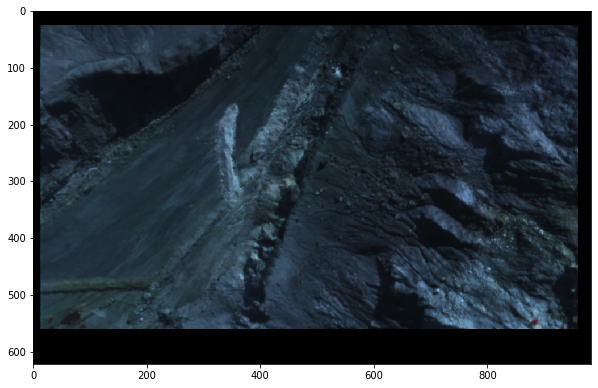

In [12]:
# Load image
i = 171
image = io.loadWithGDAL(images[i]) 
print("Loaded image " + str(images[i].stem) + " with %d samples (x), %d lines (y) and %d bands." % (image.samples(), image.lines(), image.band_count()))

# Plot it
fig, ax = plt.subplots(figsize=(10, 10))
fig, ax = image.quick_plot(band=(45, 20, 10), ax=ax)

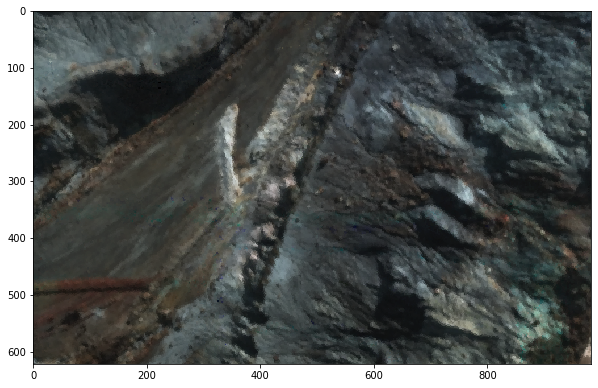

In [14]:
# Plot estimated camera view
ortho = cloud.render(image.header.get_camera(), 
                     fill_holes=True, 
                     blur=True,
                     s=2, 
                     bands='rgb')
fig,ax = plt.subplots(figsize=(10, 10))
fig,ax = ortho.quick_plot(band=(0, 1, 2), ax=ax)

# 2.3 Extract reference targets

Select hyperspectral image containing reference targets. The image is optimally taken spatially and timely close to the rest of the acquisition and at a similar altitude: 

(<Figure size 1296x820.053 with 1 Axes>, <AxesSubplot:>)

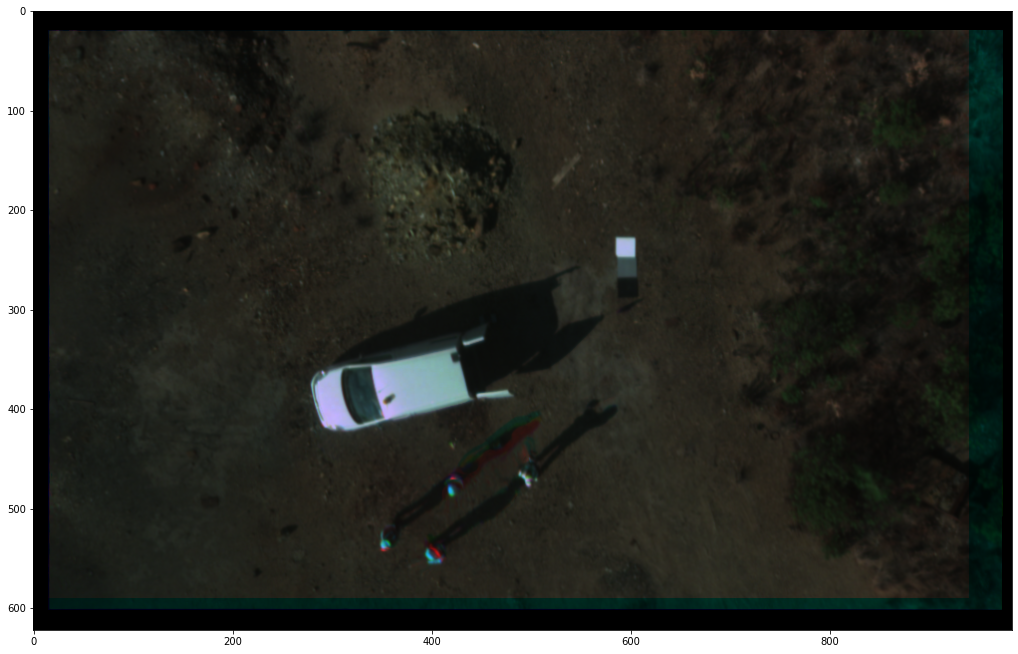

In [4]:
ref_path = 'Calib_K00074_CORRECTED.hdr'
ref_image = io.loadWithGDAL(flpth + ref_path) # Load image
ref_image.quick_plot(band=hylite.RGB)

Define calibration panel material:

In [5]:
from hylite.reference.spectra import R90, R50, PVC_Red, PVC_White, PVC_Grey, PVC_Black # Load calibration material spectra
M = [PVC_Grey, PVC_Black] # Define calibration panel material

Manually select targets from image

In [6]:
targets = []
for i, m in enumerate(M):
    target = Panel(m, ref_image, method='manual', bands=hylite.RGB) # Select panel, change method to "sobel" for auto detection
    targets.append(target) # Store

Plot targets

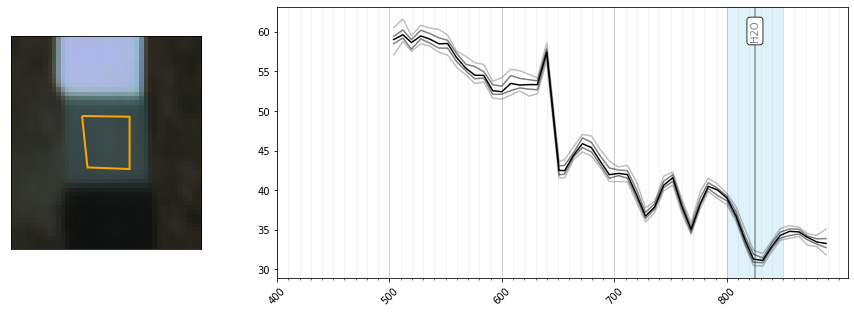

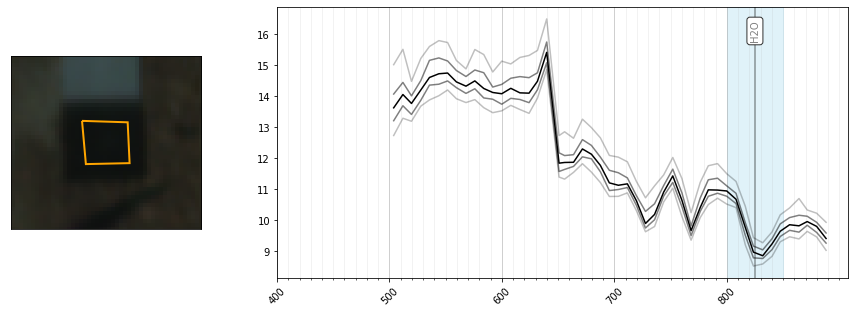

In [7]:
%matplotlib inline
for i, t in enumerate(targets):
    fig,ax = t.quick_plot()
    fig.show()

Save reference information to header

In [ ]:
for i, p in enumerate(tqdm(images)):

    # Load image header
    head = io.loadHeader(io.matchHeader(p)[0])

    # Add to header
    for j, t in enumerate(targets):
        head.add_panel(t)

    # Save to disk
    outpath = io.matchHeader(p)[0]
    io.saveHeader(outpath, head)